In [25]:
import numpy as np
import matplotlib.pyplot as plt

In [26]:
#we need to read the file
#../input_data/trajNaCl.pdb
#500 timeframes

#bash command to filter
#grep ATOM trajNaCl.pdb | tr -s ' ' | cut -d' ' -f6-8 > filter_trajNaCl.txt

In [33]:
def data_init():
    data = np.loadtxt("../input_data/filter_trajNaCl.txt") #500 blocks of 40 lines
    cell = 31.47
    bins = 16 #total number of bins, also affects the amount of values g gets
    ngr = 0 # what is ngr for ?
    delg = cell/(2*bins) #delg is bin size
    g = np.zeros(bins) 
    #First chunk over
    chunk = 40
    npart = chunk*501 #amount of particles, 20040
    return data, cell, bins, ngr, delg, g, npart, chunk

In [28]:
#Based on Frenkel
def rdf(g, ngr, cell, data, delg, npart, chunk):
    for k in range(0, npart, chunk): #k for the different chunks/timeframes
        ngr = ngr + 1   #not very improtant, only used for normalization
        for i in range(k+0, k+chunk-1):
            for j in range(i+1, k+chunk): #This should be OK
                #distance between a particle pair
                r = data[i]-data[j]
                #implement periodic boundary conditions
                r = r - cell*np.round(r/cell) # ok
                r = np.linalg.norm(r) # ok
                #half-box check & contribution
                if r <= cell/2: #what is the reasoning here? 
                    #without the above condition, index l is out of bounds
                    l = int(r/(delg))
                    g[l] = g[l] + 2
    return g, ngr

In [14]:
#Attempt to my own understanding
def rdf_variant(cell, data, npart, chunk):
    bins = 7
    d = np.zeros(bins)
    rMax = bins # should be connected to the number of bins somehow
    #for a cell of size 31, bins = 7 makes the most sense for an rMax of 14-15
    for k in range(0, npart, chunk):
        for i in range(k+0, k+chunk-1):
            for j in range(i+1, k+chunk):
                r = data[i]-data[j]
                r = r - cell*np.round(r/cell)
                r = np.linalg.norm(r)
                index = np.round(bins*(r/rMax)) #Finding the shell that the particle is in
                d[index] = d[index] + 2 #+1 or +2? +2 makes more sense
    return d

In [39]:
def grdf(g, ngr, bins, npart, cell):
    rho = npart/(cell**3)
    r = []
    for i in range(0, bins): #i in [0, bins), inc +1
        r.append(delg*(i+0.5))  #So this will be the x-axis
        vol = ((i+1)**3  - i**3 )*delg**3 #what?
        nid = (4/3)*np.pi*vol*rho
        #vol and nid, seem a bit weird to me
        g[i] = g[i]/(ngr*npart*nid)  
        #This is the normalization part, I need a a proper value for rho
        #Not so important for now
    return g, r

In [40]:
data, cell, bins, ngr, delg, g, npart, chunk = data_init()

In [41]:
g, ngr = rdf(g, ngr, cell, data, delg, npart, chunk)

In [42]:
g

array([    0.,     0.,  1114.,  1440.,  5424., 12230., 12170., 17964.,
       21322., 27052., 33430., 39956., 46348., 54888., 63670., 72150.])

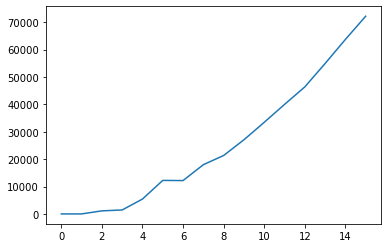

In [43]:
plt.plot(g)

In [44]:
g, r = grdf(g, ngr, bins, npart, cell)

In [45]:
print("length of g:", np.size(g))
print("values of g:", g)

length of g: 16
values of g: [0.00000000e+00 0.00000000e+00 2.27960581e-06 1.51317422e-06
 3.45714831e-06 5.22532407e-06 3.72576126e-06 4.13280113e-06
 3.82029034e-06 3.88113057e-06 3.92677980e-06 3.91308844e-06
 3.84225621e-06 3.90137993e-06 3.92313864e-06 3.89071336e-06]


(0.0, 5.7478564761386065e-06)

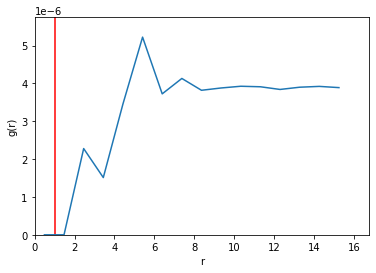

In [46]:
plt.plot(r, g)
plt.xlabel('r')
plt.vlines(1, 0, 2*np.max(g), colors="red")
plt.ylabel('g(r)')
plt.xlim( (0, np.max(r)*1.1) )
plt.ylim( (0, np.max(g)*1.1) )